# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change to your working directory
#%cd "/content/drive/MyDrive/shared folder/Master_Thesis"
%cd "/content/drive/MyDrive/shared_folder/Master_Thesis" 

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


In [ ]:
!pip install adapt

     |████████████████████████████████| 83 kB 1.5 MB/s 
     |████████████████████████████████| 462 kB 34.4 MB/s 
  Created wheel for adapt: filename=adapt-0.4.1-py3-none-any.whl size=105169 sha256=c2f2d4ff179e77744804e54913ed2f386a03d88993feb2d2af41ee8d5b79dd24
  Stored in directory: /root/.cache/pip/wheels/84/70/4b/23d24c3b067b3ab9c051d3ac1a63ba632b6ca6a45b633ace7e
Successfully built adapt


In [ ]:
import os, random, shutil, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise 
from tensorflow.keras.layers import BatchNormalization,  GlobalMaxPooling2D, GlobalAveragePooling2D,  Add
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet50V2, MobileNetV3Large
from tensorflow.keras.constraints import MinMaxNorm, MaxNorm
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

from adapt.parameter_based import FineTuning
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

In [ ]:
print("GPU Available: ", tf.test.is_gpu_available())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
2.8.0


In [ ]:
# Original Dataset
Source_dir_train1 = "./Images/DANN/Source/LC25000_mix_data_512_3200_train1.pkl"
Source_dir_train2 = "./Images/DANN/Source/LC25000_mix_data_512_3200_train2.pkl"
Source_dir_train3 = "./Images/DANN/Source/LC25000_mix_data_512_3200_train3.pkl"


Target_dir_train1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_512_3200_train1.pkl")
Target_dir_train2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_512_3200_train2.pkl")
Target_dir_test1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_512_3200_test1.pkl")
Target_dir_test2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_512_3200_test2.pkl")

# Cyclegan Dataset

Target_cyclegan_dir_train1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_512_3200_train1.pkl")
Target_cyclegan_dir_train2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_512_3200_train2.pkl")
Target_cyclegan_dir_test1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_512_3200_test1.pkl")
Target_cyclegan_dir_test2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_512_3200_test2.pkl")

In [ ]:
CHANNELS = 3
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512

# Loading Dataset

## configuration

In [ ]:
#rescale
def convert(data_list):
    for i in range(len(data_list)): data_list[i]=data_list[i]/255

In [ ]:
# Data Augmentation
def augment(image):
    image = np.array(image, dtype=np.float32)
    #image = (image / 255.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.15, seed=1)
    image = tf.image.random_hue(image, max_delta=0.09, seed=1)
    return image

def augment_1(image):
    image = np.array(image, dtype=np.float32)
    image = (image / 255.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.15, seed=1)
    image = tf.image.random_hue(image, max_delta=0.09, seed=1)
    return image

# process dataset
def data_augmentation(dataset):
    au=[]
    for file in dataset:
        file_au = augment(file)
        au.append(file_au)
    return au

## LC25000 Data Augmentation Dataset

In [ ]:
# LC25000 Dataset
with open(os.path.abspath(Source_dir_train1), "rb") as f:
    LC25000_train1 = pickle.load(f)
with open(os.path.abspath(Source_dir_train2), "rb") as f:
    LC25000_train2 = pickle.load(f)
with open(os.path.abspath(Source_dir_train3), "rb") as f:
    LC25000_train3 = pickle.load(f)

In [ ]:
LC25000_train_data = LC25000_train1['train'][0:533] + LC25000_train2['train'][0:534] + LC25000_train3['train'][0:533] 
LC25000_train_labels = np.concatenate((LC25000_train1['train_label'][0:533],LC25000_train2['train_label'][0:534],LC25000_train3['train_label'][0:533]))
# LC25000_train_data = LC25000_train1['train'] + LC25000_train2['train'] + LC25000_train3['train'] 
# LC25000_train_labels = np.concatenate((LC25000_train1['train_label'],LC25000_train2['train_label'],LC25000_train3['train_label']))

In [ ]:
LC25000_train_lab = tf.one_hot(LC25000_train_labels, depth=3)

### Data Augmentation Process

In [ ]:
LC25000_train_data_au = data_augmentation(LC25000_train_data)

In [ ]:
LC25000_train_data_au = np.array(LC25000_train_data_au, dtype=np.float32)

In [ ]:
print("The shape of LC25000_train_data: ", LC25000_train_data_au.shape)
print("The shape of LC25000_train_labels: ", LC25000_train_labels.shape)

The shape of LC25000_train_data:  (1600, 512, 512, 3)
The shape of LC25000_train_labels:  (1600,)


In [ ]:
import gc
gc.collect()

125

## TCGA Dataset

In [ ]:
# TCGA Dataset
with open(os.path.abspath(Target_dir_train1), "rb") as f:
    TCGA_train1 = pickle.load(f)
with open(os.path.abspath(Target_dir_train2), "rb") as f:
    TCGA_train2 = pickle.load(f)
# with open(os.path.abspath(Target_dir_train1), "rb") as f:
#     TCGA_train1 = pickle.load(f)
# with open(os.path.abspath(Target_dir_test1), "rb") as f:
#     TCGA_test1 = pickle.load(f)
# with open(os.path.abspath(Target_dir_train2), "rb") as f:
#     TCGA_train2 = pickle.load(f)
# with open(os.path.abspath(Target_dir_test2), "rb") as f:
#     TCGA_test2 = pickle.load(f)

In [ ]:
TCGA_train_data = TCGA_train1['train'][0:800] + TCGA_train2['train'][0:800]
TCGA_train_labels = np.concatenate((TCGA_train1['train_label'][0:800],TCGA_train2['train_label'][0:800]))
# TCGA_train_data = TCGA_train1['train'] + TCGA_train2['train']
# TCGA_train_labels = np.concatenate((TCGA_train1['train_label'],TCGA_train2['train_label']))
# TCGA_test_data = TCGA_test1['test'] + TCGA_test2['test']
# TCGA_test_labels = np.concatenate((TCGA_test1['test_label'],TCGA_test2['test_label']))

In [ ]:
TCGA_train_lab = tf.one_hot(TCGA_train_labels, depth=3)
# TCGA_test_lab = tf.one_hot(TCGA_test_labels, depth=3)
TCGA_train_data = np.array(TCGA_train_data, dtype=np.float32)
# TCGA_test_data = np.array(TCGA_test_data, dtype=np.float32)

In [ ]:
print("The shape of TCGA_train_data: ", np.shape(TCGA_train_data))
print("The shape of TCGA_train_labels: ", np.shape(TCGA_train_labels))
# print("The shape of TCGA_test_data: ", np.shape(TCGA_test_data))
# print("The shape of TCGA_test_labels: " , np.shape(TCGA_test_labels))

The shape of TCGA_train_data:  (1600, 512, 512, 3)
The shape of TCGA_train_labels:  (1600,)


In [ ]:
import gc
gc.collect()

22

In [ ]:
TCGA_train_labels

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
import csv
with open('TCGA_DIR_train_byclass_file_512_test.csv', 'w') as csvfile:
    for file_name in TCGA_train_labels:
        print(file_name, file=csvfile)

## Datasets Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


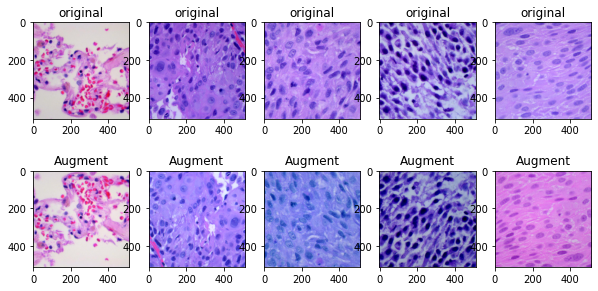

In [ ]:
# show the difference bewteen Original images and Data Augmentation images
fig = plt.figure(figsize=(10, 10))

for i in range(5):
    sample = random.choice(LC25000_train_data)
    fig.add_subplot(2,5,i+1)
    img = array_to_img(sample)
    plt.title("original")
    plt.imshow(img)
    fig.add_subplot(1,5,i+1)
    img1 = augment_1(sample)
    plt.title("Augment")
    plt.imshow(img1)

<function matplotlib.pyplot.show>

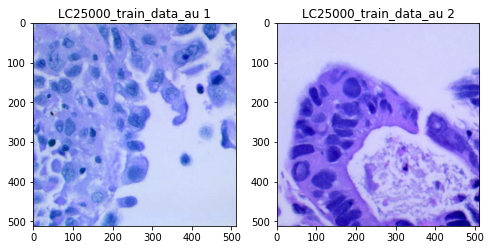

In [ ]:
# random show images
plt.subplots(1,2,figsize=(8,8))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(LC25000_train_data_au)
img1 = array_to_img(sample1)
plt.title("LC25000_train_data_au 1")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(LC25000_train_data_au)
img2 = array_to_img(sample2)
plt.title("LC25000_train_data_au 2")
plt.imshow(img2)
plt.show

<function matplotlib.pyplot.show>

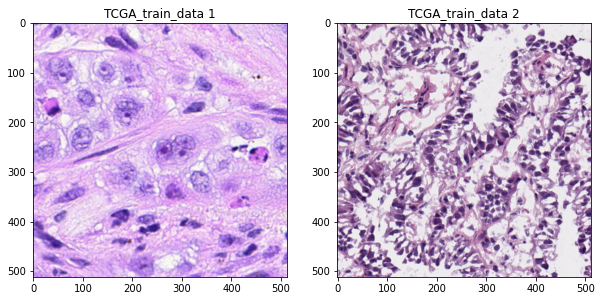

In [ ]:
# random show Target images
plt.subplots(1,2,figsize=(10,10))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(TCGA_train_data)
img1 = array_to_img(sample1)
plt.title("TCGA_train_data 1")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(TCGA_train_data)
img2 = array_to_img(sample2)
plt.title("TCGA_train_data 2")
plt.imshow(img2)
plt.show

# Domain Adaptation

## Build Model

### Feature Extractor - ResNet50V2

In [ ]:
resnet50 = ResNet50(include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), pooling="avg")

first_layer = resnet50.get_layer('conv5_block2_out')
inputs = Input(first_layer.output_shape[1:])

for layer in resnet50.layers[resnet50.layers.index(first_layer)+1:]:
    if layer.name == "conv5_block3_1_conv":
        x = layer(inputs)
    elif layer.name == "conv5_block3_add":  # change name
        x = layer([inputs, x])
    else:
        if layer.name == "conv5_block3_preact_bn":
            pass
        else:
            x = layer(x)

first_blocks = Model(resnet50.input, first_layer.output)
last_block = Model(inputs, x)

In [ ]:
def load_resnet50(path="./Model/DANN_Model/resnet50_last_block_512.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

last_block.summary()
last_block.save("./Model/DANN_Model/resnet50_last_block_512.hdf5")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 16, 16, 204  0           []                               
                                8)]                                                               
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 16, 16, 512)  1049088     ['input_2[0][0]']                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 16, 16, 512)  2048       ['conv5_block3_1_conv[1][0]']    
 ization)                                                                                         
                                                                                            

### Extract the features 

In [ ]:
LC25000_train_data_au_ex = first_blocks.predict(preprocess_input(np.stack(LC25000_train_data_au)))

In [ ]:
gc.collect()

5860

In [ ]:
TCGA_train_data_ex = first_blocks.predict(preprocess_input(np.stack(TCGA_train_data)))

In [ ]:
del LC25000_train_data
gc.collect()

686

In [ ]:
print("LC25000_train_data_au (source) shape: %s"%str(LC25000_train_data_au.shape))
print("TCGA_train_data (target) shape: %s"%str(TCGA_train_data.shape))

LC25000_train_data_au (source) shape: (1600, 512, 512, 3)
TCGA_train_data (target) shape: (1600, 512, 512, 3)


### Label Predictor

In [ ]:
def get_task(dropout=0.5, max_norm=0.5):
    model = Sequential()
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation="softmax",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    return model

In [ ]:
class MyDecay(LearningRateSchedule):

    def __init__(self, max_steps=1000, mu_0=0.01, alpha=10, beta=0.75):
        self.mu_0 = mu_0
        self.alpha = alpha
        self.beta = beta
        self.max_steps = float(max_steps)

    def __call__(self, step):
        p = step / self.max_steps
        return self.mu_0 / (1+self.alpha * p)**self.beta

# Fit without adaptation

### Run 1

In [ ]:
lr = 1e-6
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=3)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=80, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/3
200/200 [==============================] - 8s 31ms/step - loss: 0.9638 - acc: 0.6062 - val_loss: 1.1416 - val_acc: 0.0306
Epoch 2/3
200/200 [==============================] - 5s 23ms/step - loss: 0.6238 - acc: 0.7900 - val_loss: 0.9735 - val_acc: 0.3963
Epoch 3/3
200/200 [==============================] - 6s 31ms/step - loss: 0.4195 - acc: 0.8750 - val_loss: 0.8215 - val_acc: 0.5763
Epoch 1/80
200/200 [==============================] - 11s 42ms/step - loss: 0.3090 - acc: 0.8969 - val_loss: 0.6440 - val_acc: 0.7050
Epoch 2/80
200/200 [==============================] - 6s 32ms/step - loss: 0.2316 - acc: 0.9212 - val_loss: 0.6160 - val_acc: 0.6956
Epoch 3/80
200/200 [==============================] - 6s 32ms/step - loss: 0.1925 - acc: 0.9319 - val_loss: 0.7080 - val_acc: 0.6500
Epoch 4/80
200/200 [==============================] - 6s 32ms/step - loss: 0.1629 - acc: 0.9456 - val_loss: 0.6358 - val_acc: 0.7038
Epoch 5/80
200/200 [==============================] - 6s 32ms/step - lo

### Run 2

In [ ]:
lr = 1e-6
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
finetunig_1 = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=3)

In [ ]:
finetunig_1.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=80, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/3
200/200 [==============================] - 10s 38ms/step - loss: 0.9977 - acc: 0.5875 - val_loss: 1.1470 - val_acc: 0.0088
Epoch 2/3
200/200 [==============================] - 5s 24ms/step - loss: 0.6955 - acc: 0.7862 - val_loss: 1.0070 - val_acc: 0.3994
Epoch 3/3
200/200 [==============================] - 5s 24ms/step - loss: 0.4606 - acc: 0.8631 - val_loss: 0.9070 - val_acc: 0.5231
Epoch 1/80
200/200 [==============================] - 12s 46ms/step - loss: 0.3228 - acc: 0.9081 - val_loss: 0.7861 - val_acc: 0.6356
Epoch 2/80
200/200 [==============================] - 7s 35ms/step - loss: 0.2418 - acc: 0.9212 - val_loss: 0.7813 - val_acc: 0.6231
Epoch 3/80
200/200 [==============================] - 7s 34ms/step - loss: 0.2022 - acc: 0.9294 - val_loss: 0.6930 - val_acc: 0.6800
Epoch 4/80
200/200 [==============================] - 7s 34ms/step - loss: 0.1826 - acc: 0.9337 - val_loss: 0.6824 - val_acc: 0.6950
Epoch 5/80
200/200 [==============================] - 7s 34ms/step - l

### Run 3

In [ ]:
lr = 1e-6
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
finetunig_1 = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=3)

In [ ]:
finetunig_1.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=80, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/3
200/200 [==============================] - 9s 36ms/step - loss: 0.9648 - acc: 0.6244 - val_loss: 1.1307 - val_acc: 0.0375
Epoch 2/3
200/200 [==============================] - 5s 26ms/step - loss: 0.6356 - acc: 0.7987 - val_loss: 1.0406 - val_acc: 0.2944
Epoch 3/3
200/200 [==============================] - 5s 23ms/step - loss: 0.4266 - acc: 0.8706 - val_loss: 0.9122 - val_acc: 0.4888
Epoch 1/80
200/200 [==============================] - 11s 45ms/step - loss: 0.3083 - acc: 0.9069 - val_loss: 0.7934 - val_acc: 0.5850
Epoch 2/80
200/200 [==============================] - 7s 34ms/step - loss: 0.2341 - acc: 0.9244 - val_loss: 0.7176 - val_acc: 0.6419
Epoch 3/80
200/200 [==============================] - 7s 34ms/step - loss: 0.2024 - acc: 0.9325 - val_loss: 0.7094 - val_acc: 0.6544
Epoch 4/80
200/200 [==============================] - 7s 34ms/step - loss: 0.1682 - acc: 0.9356 - val_loss: 0.7148 - val_acc: 0.6594
Epoch 5/80
200/200 [==============================] - 7s 34ms/step - lo

### Run 4

In [ ]:
lr = 1e-6
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
finetunig_1 = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=3)

In [ ]:
finetunig_1.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=80, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/3
200/200 [==============================] - 9s 38ms/step - loss: 0.9711 - acc: 0.6156 - val_loss: 1.1151 - val_acc: 0.0269
Epoch 2/3
200/200 [==============================] - 5s 26ms/step - loss: 0.6526 - acc: 0.7794 - val_loss: 1.0200 - val_acc: 0.2856
Epoch 3/3
200/200 [==============================] - 5s 24ms/step - loss: 0.4370 - acc: 0.8750 - val_loss: 0.8099 - val_acc: 0.5919
Epoch 1/80
200/200 [==============================] - 12s 45ms/step - loss: 0.3160 - acc: 0.8975 - val_loss: 0.7708 - val_acc: 0.6075
Epoch 2/80
200/200 [==============================] - 7s 36ms/step - loss: 0.2431 - acc: 0.9194 - val_loss: 0.7000 - val_acc: 0.6444
Epoch 3/80
200/200 [==============================] - 7s 36ms/step - loss: 0.1966 - acc: 0.9344 - val_loss: 0.6858 - val_acc: 0.6569
Epoch 4/80
200/200 [==============================] - 7s 37ms/step - loss: 0.1726 - acc: 0.9344 - val_loss: 0.7825 - val_acc: 0.6194
Epoch 5/80
200/200 [==============================] - 7s 37ms/step - lo

### Run 5

In [ ]:
lr = 1e-6
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
finetunig_1 = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=3)

In [ ]:
finetunig_1.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=80, batch_size=8, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/3
200/200 [==============================] - 7s 28ms/step - loss: 0.9637 - acc: 0.6206 - val_loss: 1.1260 - val_acc: 0.0388
Epoch 2/3
200/200 [==============================] - 7s 35ms/step - loss: 0.6490 - acc: 0.8050 - val_loss: 1.0514 - val_acc: 0.2531
Epoch 3/3
200/200 [==============================] - 7s 35ms/step - loss: 0.4334 - acc: 0.8906 - val_loss: 0.8306 - val_acc: 0.5781
Epoch 1/80
200/200 [==============================] - 11s 47ms/step - loss: 0.3116 - acc: 0.9044 - val_loss: 0.7818 - val_acc: 0.5919
Epoch 2/80
200/200 [==============================] - 8s 40ms/step - loss: 0.2341 - acc: 0.9244 - val_loss: 0.7072 - val_acc: 0.6400
Epoch 3/80
200/200 [==============================] - 8s 41ms/step - loss: 0.2036 - acc: 0.9294 - val_loss: 0.6369 - val_acc: 0.7038
Epoch 4/80
200/200 [==============================] - 8s 40ms/step - loss: 0.1752 - acc: 0.9394 - val_loss: 0.6016 - val_acc: 0.7200
Epoch 5/80
200/200 [==============================] - 8s 40ms/step - lo

### Result

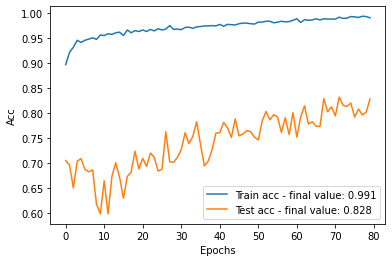

In [ ]:
acc = finetunig.history.history["acc"]; val_acc = finetunig.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


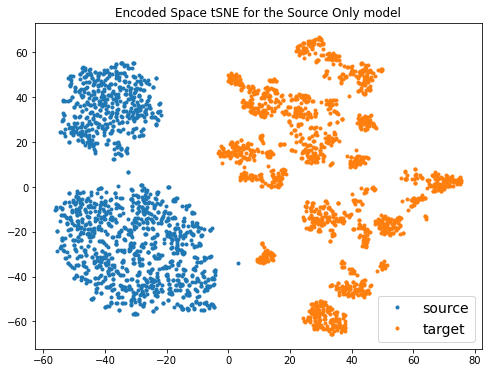

In [ ]:
LC25000_train_data_au_enc = finetunig.transform(LC25000_train_data_au_ex)
TCGA_train_data_enc = finetunig.transform(TCGA_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_au_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_au_ex), 0], X_tsne[:len(LC25000_train_data_au_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_au_ex):, 0], X_tsne[len(LC25000_train_data_au_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the Source Only model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(finetunig.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,val_loss,val_acc
count,80.000000,80.000000,80.000000,80.000000
mean,0.078377,0.972195,0.877567,0.742211
std,0.047562,0.017242,0.104719,0.056060
min,0.024635,0.896875,0.615982,0.598125
25%,0.045030,0.964844,0.816433,0.701094
50%,0.069495,0.975000,0.883653,0.753750
75%,0.097851,0.984219,0.953276,0.788750
max,0.308960,0.993750,1.086972,0.831875


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_512/MDD_source_Resnet_512_RMS_1e-6_AU.csv")

# Fit with adaptation

### Run 1

In [ ]:
lr = 1e-6
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd_1 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_1.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/150
200/200 [==============================] - 14s 50ms/step - loss: 0.9609 - acc: 0.6181 - disc_loss: 1.4803 - val_loss: 0.7983 - val_acc: 0.9569
Epoch 2/150
200/200 [==============================] - 9s 45ms/step - loss: 0.6033 - acc: 0.8081 - disc_loss: 1.4206 - val_loss: 0.6477 - val_acc: 0.8788
Epoch 3/150
200/200 [==============================] - 9s 44ms/step - loss: 0.3873 - acc: 0.8706 - disc_loss: 1.3738 - val_loss: 0.4904 - val_acc: 0.8988
Epoch 4/150
200/200 [==============================] - 9s 44ms/step - loss: 0.2626 - acc: 0.9081 - disc_loss: 1.3201 - val_loss: 0.4345 - val_acc: 0.8750
Epoch 5/150
200/200 [==============================] - 9s 44ms/step - loss: 0.1924 - acc: 0.9388 - disc_loss: 1.2533 - val_loss: 0.3652 - val_acc: 0.8863
Epoch 6/150
200/200 [==============================] - 9s 44ms/step - loss: 0.1721 - acc: 0.9319 - disc_loss: 1.1838 - val_loss: 0.3837 - val_acc: 0.8562
Epoch 7/150
200/200 [==============================] - 9s 44ms/step - loss:

### Run 2

In [ ]:
lr = 1e-6
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd_1 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_1.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/150
200/200 [==============================] - 17s 52ms/step - loss: 0.9701 - acc: 0.5656 - disc_loss: 1.4837 - val_loss: 0.8264 - val_acc: 0.9688
Epoch 2/150
200/200 [==============================] - 10s 48ms/step - loss: 0.6392 - acc: 0.8094 - disc_loss: 1.4113 - val_loss: 0.7270 - val_acc: 0.8675
Epoch 3/150
200/200 [==============================] - 9s 44ms/step - loss: 0.4002 - acc: 0.8731 - disc_loss: 1.3700 - val_loss: 0.6121 - val_acc: 0.8275
Epoch 4/150
200/200 [==============================] - 9s 43ms/step - loss: 0.2724 - acc: 0.9119 - disc_loss: 1.3135 - val_loss: 0.4403 - val_acc: 0.8687
Epoch 5/150
200/200 [==============================] - 9s 43ms/step - loss: 0.2142 - acc: 0.9262 - disc_loss: 1.2471 - val_loss: 0.4425 - val_acc: 0.8388
Epoch 6/150
200/200 [==============================] - 9s 43ms/step - loss: 0.1748 - acc: 0.9425 - disc_loss: 1.1765 - val_loss: 0.4659 - val_acc: 0.8150
Epoch 7/150
200/200 [==============================] - 8s 42ms/step - loss

### Run 3

In [ ]:
lr = 1e-6
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd_1 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_1.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/150
200/200 [==============================] - 15s 52ms/step - loss: 0.9698 - acc: 0.5950 - disc_loss: 1.4939 - val_loss: 0.8240 - val_acc: 0.9156
Epoch 2/150
200/200 [==============================] - 9s 46ms/step - loss: 0.6210 - acc: 0.7844 - disc_loss: 1.4357 - val_loss: 0.7303 - val_acc: 0.8425
Epoch 3/150
200/200 [==============================] - 9s 43ms/step - loss: 0.3883 - acc: 0.8619 - disc_loss: 1.3835 - val_loss: 0.6076 - val_acc: 0.8244
Epoch 4/150
200/200 [==============================] - 8s 42ms/step - loss: 0.2736 - acc: 0.9075 - disc_loss: 1.3252 - val_loss: 0.4946 - val_acc: 0.8363
Epoch 5/150
200/200 [==============================] - 8s 42ms/step - loss: 0.2135 - acc: 0.9225 - disc_loss: 1.2844 - val_loss: 0.3969 - val_acc: 0.8656
Epoch 6/150
200/200 [==============================] - 8s 42ms/step - loss: 0.1974 - acc: 0.9225 - disc_loss: 1.2150 - val_loss: 0.5027 - val_acc: 0.7931
Epoch 7/150
200/200 [==============================] - 8s 42ms/step - loss:

### Run 4

In [ ]:
lr = 1e-6
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd_1 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_1.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/150
200/200 [==============================] - 15s 52ms/step - loss: 0.9429 - acc: 0.6363 - disc_loss: 1.5267 - val_loss: 0.7665 - val_acc: 0.9875
Epoch 2/150
200/200 [==============================] - 9s 43ms/step - loss: 0.6187 - acc: 0.8056 - disc_loss: 1.4380 - val_loss: 0.6569 - val_acc: 0.9038
Epoch 3/150
200/200 [==============================] - 9s 43ms/step - loss: 0.3864 - acc: 0.8681 - disc_loss: 1.3832 - val_loss: 0.5178 - val_acc: 0.8763
Epoch 4/150
200/200 [==============================] - 9s 43ms/step - loss: 0.2733 - acc: 0.9038 - disc_loss: 1.3284 - val_loss: 0.4272 - val_acc: 0.8719
Epoch 5/150
200/200 [==============================] - 9s 43ms/step - loss: 0.2080 - acc: 0.9294 - disc_loss: 1.2817 - val_loss: 0.4760 - val_acc: 0.8194
Epoch 6/150
200/200 [==============================] - 8s 42ms/step - loss: 0.1774 - acc: 0.9394 - disc_loss: 1.2226 - val_loss: 0.5132 - val_acc: 0.7844
Epoch 7/150
200/200 [==============================] - 8s 42ms/step - loss:

### Run 5

In [ ]:
lr = 1e-6
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd_1 = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd_1.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=150, batch_size=8,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/150
200/200 [==============================] - 15s 52ms/step - loss: 0.9608 - acc: 0.6062 - disc_loss: 1.4909 - val_loss: 0.8038 - val_acc: 0.9669
Epoch 2/150
200/200 [==============================] - 9s 44ms/step - loss: 0.6207 - acc: 0.8012 - disc_loss: 1.4182 - val_loss: 0.6099 - val_acc: 0.9319
Epoch 3/150
200/200 [==============================] - 9s 43ms/step - loss: 0.3969 - acc: 0.8600 - disc_loss: 1.3678 - val_loss: 0.4708 - val_acc: 0.9219
Epoch 4/150
200/200 [==============================] - 9s 43ms/step - loss: 0.2884 - acc: 0.9069 - disc_loss: 1.3277 - val_loss: 0.3890 - val_acc: 0.9006
Epoch 5/150
200/200 [==============================] - 9s 43ms/step - loss: 0.2138 - acc: 0.9275 - disc_loss: 1.2550 - val_loss: 0.4110 - val_acc: 0.8506
Epoch 6/150
200/200 [==============================] - 9s 43ms/step - loss: 0.1885 - acc: 0.9325 - disc_loss: 1.2038 - val_loss: 0.3762 - val_acc: 0.8731
Epoch 7/150
200/200 [==============================] - 9s 43ms/step - loss:

### Result

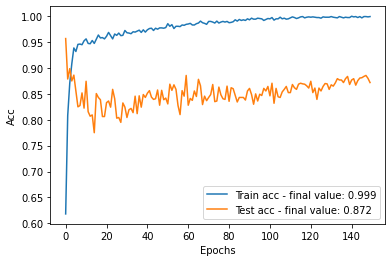

In [ ]:
acc = mdd_1.history.history["acc"]; val_acc = mdd_1.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


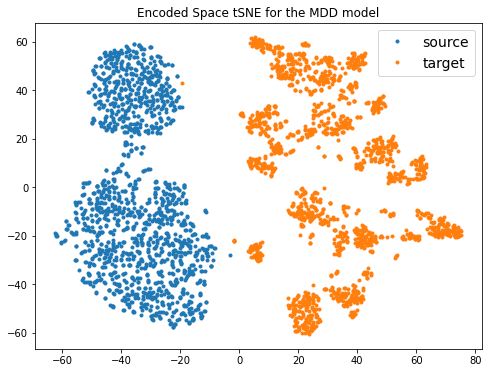

In [ ]:
LC25000_train_data_au_enc = mdd_1.transform(LC25000_train_data_au_ex)
TCGA_train_data_enc = mdd_1.transform(TCGA_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_au_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_au_ex), 0], X_tsne[:len(LC25000_train_data_au_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_au_ex):, 0], X_tsne[len(LC25000_train_data_au_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the MDD model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(mdd_1.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,disc_loss,val_loss,val_acc
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.061443,0.978779,0.332966,0.649059,0.850767
std,0.101468,0.038154,0.297593,0.131932,0.023432
min,0.004208,0.618125,0.032862,0.345292,0.775000
25%,0.013202,0.972500,0.134110,0.534179,0.837656
50%,0.035192,0.988750,0.233352,0.694481,0.852188
75%,0.079814,0.996875,0.389069,0.756938,0.867344
max,0.960929,1.000000,1.415561,0.919093,0.956875


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_512/MDD_Resnet_512_RMS_1e-6_g1_AU.csv")